# Project For P2 - Introduction To Data Analysis

### Author - Marcelo de Sena Lacerda

## Introduction
This project seeks to analyze [Lahman’s Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) from 1871 to 2015. I am going to analyze and try to understand the relationship between player salaries and receiving awards.

## The data set

In seanlahman.com several options for acquiring the data set are given(access, CSV and sql), for this project it was chosen the CSV files since they can be easily imported with the [pandas](http://pandas.pydata.org/) library.

The dataset comes in a zip bundle that contains several CSV files(referred also as tables through the rest of this project). Each table relates to a set of statistics about pitching, hitting, and fielding statistics for american baseball games from 1871 through 2015. The layout of the contents of CSV files(the order of the columns) and the detailed description of each column can be found in the [dataset readme](http://seanlahman.com/files/database/readme2014.txt).


For this project I'm going to analyze the relationship between player salary and having an award. For those two factors, having an award and yearly salary several questions can be raised:

1. Do salaries increase when a player receives an award?
2. Do salaries increase before a player receives an award?
3. Do salaries keep increasing the more awards a player gets?
4. By how much is a salary expected to increase after an award?
5. Do players that receive awards tend to play in the same teams?
6. Is there an award winning player creep in teams?(Are some teams collecting award winning players and not hiring other players)?

Since the time to analyze that dataset is limited the time it takes to answer any of those questions is greater than I initially expected I tried to focus on only the first question.


## The preliminary analysis

Now, before proceeding I must first do a bit of a bootstrap, import the libraries that I'm going to use and load the dataset.

In [1]:
import pandas as pd, os.path, numpy as np, humanize
%matplotlib inline
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
salaries_table = pd.read_csv(os.path.join('csvs', 'Salaries.csv'))
awards_table = pd.read_csv(os.path.join('csvs', 'AwardsPlayers.csv'))

Next I should take a look to see if everything is alright. It's also important to know wether there are some null fields in our tables as they may influence our study.

In [2]:
print 'Salaries table'
print salaries_table.head()
print "Salaries's empty values"
print salaries_table.isnull().sum()
print 'Awards table'
print awards_table.head()
print "Awards's empty values"
print awards_table.isnull().sum()

Salaries table
   yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000
Salaries's empty values
yearID      0
teamID      0
lgID        0
playerID    0
salary      0
dtype: int64
Awards table
    playerID                awardID  yearID lgID  tie notes
0   bondto01  Pitching Triple Crown    1877   NL  NaN   NaN
1  hinespa01           Triple Crown    1878   NL  NaN   NaN
2  heckegu01  Pitching Triple Crown    1884   AA  NaN   NaN
3  radboch01  Pitching Triple Crown    1884   NL  NaN   NaN
4  oneilti01           Triple Crown    1887   AA  NaN   NaN
Awards's empty values
playerID       0
awardID        0
yearID         0
lgID           0
tie         6033
notes       1430
dtype: int64


Everything seems to be in order, there are two fields with a significant number of fields in the awards table, but we are not interested in the information that some awards are tied with other players, nor we care about the notes about the awards.

Next I should gather some basic statistics about the salaries.

In [3]:
ksalary = salaries_table['salary']/1000
ksalary.describe().apply(lambda x: humanize.intcomma(int(x)))

count    25,575
mean      2,008
std       3,315
min           0
25%         275
50%         550
75%       2,250
max      33,000
Name: salary, dtype: object

Here we can see that more than half of all salaries are below 1 million but the mean is 2 million, this must mean that we have few players that win far above 1 million that are pulling the mean up, the standard deviation of 3 million is further evidence of an uneven distribution.

In [4]:
print 'Year with most awards:', int(awards_table['yearID'].mode())
print 'Median of the years:', int(awards_table['yearID'].median())

Year with most awards: 2007
Median of the years: 1974


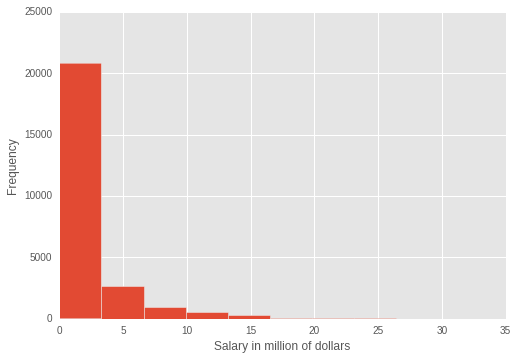

In [5]:
plt.figure()
axes = (ksalary/1000).hist()
axes.set_xlabel("Salary in million of dollars")
axes.set_ylabel("Frequency")

This chart confirms our suspicions that the salary distribution is positively skewed and very uneven. But there seems to be some data points too small to be seen on the far right of the histogram. Let's try to see them on a boxplot.

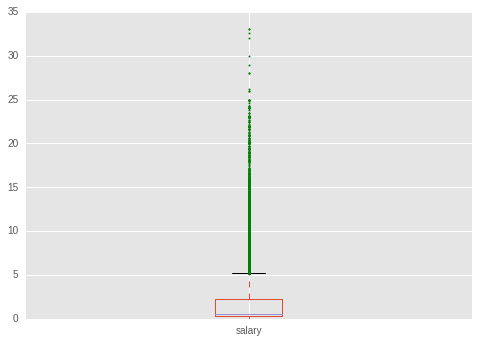

In [6]:
axes = (ksalary/1000).plot.box(flierprops = dict(marker='o', markerfacecolor='green', markersize=2,
                  linestyle='none'))

There is a lot of outliers in the plot that explain how our standard deviation is so big and how our mean is almost 4 times bigger than our median.

We should also take a look at our awards table, one interesting question to ask is how are the awards distributed over time, in other words, do the number of awards granted vary as time passes?

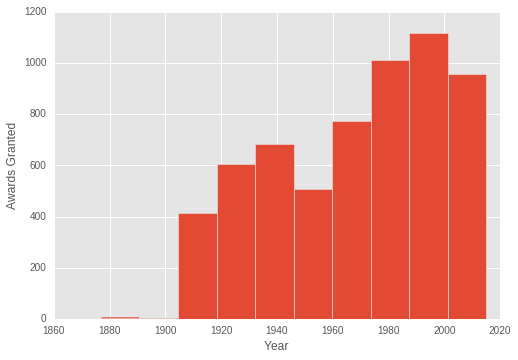

In [7]:
awards_table[['yearID']].hist()
plt.xlabel('Year')
plt.ylabel('Awards Granted')
plt.title('')

plt.show()

It seems like awards granted increase with time.

## Analysing the relationship between player salaries and receiving an award

The question I was set to answer is do salaries increase with awards, but soon after starting to investigating the issue I realized that I cannot answer the question before asking if salaries increase regardless, in other words, is there inflation in the salaries? To answer that question I plotted the average player salaries over time.

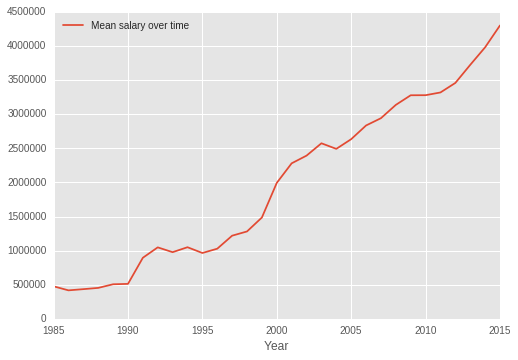

In [12]:
average_mean_salaries = pd.DataFrame()
average_mean_salaries['Mean salary over time'] = salaries_table.groupby('yearID')['salary'].mean()
axes = average_mean_salaries.plot()
axes.set_xlabel('Year')

From that plot I suspected that I couldn't use a salary delta(salary after an award - salary before an award) to test whether salaries increase because the deltas could be highly influenced for the inflation of that year. I could try to isolate the effect of inflation but doing so would amplify the scope of this project greatly.

Instead, as suggested on the [forums](https://discussions.udacity.com/t/testing-for-correlation-between-the-salaries-of-baseball-players-and-awards-won/185580/2?u=msl09) I decided to analyze if the average salary for players that won an award is greater than it is for players that didn't win an award and compare that with the average salary for players who didn't win an award.

### Retrieve a list of players that got an award.

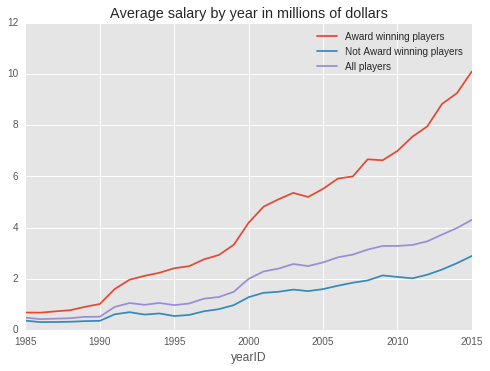

In [13]:
winners = salaries_table[salaries_table.playerID.isin(awards_table['playerID'])]
nonwinners = salaries_table[~salaries_table.playerID.isin(awards_table['playerID'])]

result = pd.DataFrame()
win = winners.groupby('yearID')['salary']
result['Award winning players'] = win.mean()
nwin = nonwinners.groupby('yearID')['salary']
result['Not Award winning players'] = nwin.mean()
result['All players'] = average_mean_salaries
result = result / 1000000
result.plot(title='Average salary by year in millions of dollars')

From the chart, although there seems to be some influence of inflation on salaries, it seems like having an award is a much better predictor of better salaries. Since doing a t-test to measure the impact of awards on salary would extend this project a lot more, this is as far as this study will go.